### 9-bus test system
 Definition of the initial 9-bus test system (originally presented in Paul M. Anderson; A. A. Fouad, "Power System Control and Stability" , IEEE, 2003, pp.i-xiv, doi: 10.1109/9780470545577.fmatter.)

### First time this should be run in terminal: 
Install libraries (if  you use uv add dependencies are added to pyproject.toml automatically, if you use uv pip install you need to add manually)

In [ ]:
# Create venv
uv venv
# Activate it
.\.venv\Scripts\activate
# Install packages in the venv
uv add highspy pyscipopt matplotlib pandas numpy cartopy
uv add jupyter
uv add pypsa

Comments:
I ran this in Visual Studio code and had to make two changes to default set up:
1) (rookie mistake): I had all the repos in a one-drive folder, which caused some issues, so i moved everything to a folder not in one-drive
2) Visual studio code has powershell as default terminal (at least in my setup) which was not permitted to activate the vevn. Just changing to command prompt solved this...

### Importing and defining models

In [11]:
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd


In [38]:
#to plot the network this is called within the create_9_bus_network if plot=True
#using first snapshot values 
def plot_network(n):
    plt.figure(figsize=(12, 8))
    # Plot base network
    n.plot(
        bus_sizes=0.01,          
        line_widths=2,          
        bus_colors='red',       
        line_colors='blue',     
        title="IEEE 9-bus System",
        margin=0.15,            
        geomap=False           
    )

    # Add bus labels and values using first snapshot
    for bus in n.buses.index:
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        p = n.buses_t.p.loc[n.snapshots[0], bus]  # Active power at first snapshot
        q = n.buses_t.q.loc[n.snapshots[0], bus]  # Reactive power at first snapshot
        plt.annotate(
            f"{bus}\nP={p:.1f} MW\nQ={q:.1f} MVAr",
            (x, y),
            xytext=(10, 10),
            textcoords='offset points'
        )

    # Add generator labels using first snapshot
    for gen in n.generators.index:
        bus = n.generators.bus[gen]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        p_set = n.generators.p_set[gen][n.snapshots[0]]  # Generator setpoint at first snapshot
        plt.annotate(
            f"G: P={n.generators.p_nom[gen]} MW\nP_set={p_set:.1f} MW",
            (x, y),
            xytext=(-10, 20),
            textcoords='offset points',
            color='green'
        )

    # Add load labels using first snapshot
    for load in n.loads.index:
        bus = n.loads.bus[load]
        x = n.buses.x[bus]
        y = n.buses.y[bus]
        p_set = n.loads.p_set[load][n.snapshots[0]]  # Load setpoint at first snapshot
        plt.annotate(
            f"L: P={p_set:.1f} MW",
            (x, y),
            xytext=(10, -20),
            textcoords='offset points',
            color='brown'
        )

    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [39]:
# In the official version generators are connected to bus 1, 2 and 3. 
# This is used as default, but can be changed by specifying bus numbers for each gen.

def create_9_bus_network(gen_bus1=1, gen_bus2=2, gen_bus3=3, plot=False):
    network = pypsa.Network()
    
    # Define five snapshots
    snapshots = pd.date_range("2025-02-12 00:00", periods=5, freq="h")
    network.set_snapshots(snapshots)
    
    # Set base MVA
    network.sbase = 100.0
    
    # IEEE 9-bus layout coordinates
    bus_coordinates = {
        1: (0, 0),      # Generator 1 (slack)
        2: (4, 0),      # Generator 2
        3: (2, 2),      # Generator 3
        4: (1, -1),     # Load bus
        5: (3, -1),     # Load bus
        6: (2, 0.5),    # Load bus
        7: (1, 1),      # Load bus
        8: (3, 1),      # Load bus
        9: (2, -1)      # Load bus
    }
    
    # Add buses with official IEEE data   
    for i in range(1, 10):
        bus_data = {
            "x": bus_coordinates[i][0],
            "y": bus_coordinates[i][1],
            "v_nom": 345 if i in [1,2,3] else 230,
            "v_mag_pu_set": 1.04 if i == gen_bus1 else 1.025 if i in [gen_bus2,gen_bus3] else 1.0,
            "v_mag_pu_min": 0.9,
            "v_mag_pu_max": 1.1,
            "type": "Slack" if i == gen_bus1 else "PV" if i in [gen_bus2,gen_bus3] else "PQ"
            }
        network.add("Bus", f"Bus {i}", **bus_data)
        
        # Add loads with oscillating patterns
        if i in [5, 7, 9]:
            # Create base loads to generate varying load patterns
            base_p = {5: 90, 7: 100, 9: 125}[i]
            base_q = {5: 30, 7: 35, 9: 50}[i]
            variation = 0.1  # 10% variation
            #oscilation pattern based on node number
            patterns = {5:np.array([1,0,1,0,-1]),
                        7:np.array([0,1,1,-1,-1]),
                        9: np.array([0,0,1,1,-1])}
            # load is set as base plus/minus a variation of 
            load_p_set = base_p * (1 + variation * patterns[i])  # Oscillating pattern
            load_q_set = base_q * (1 + variation * patterns[i])  # Oscillating pattern
            
            network.add("Load", f"Load {i}", 
                bus=f"Bus {i}",
                p_set=pd.Series(load_p_set, index=snapshots),
                q_set=pd.Series(load_q_set, index=snapshots))
    
    ## Add Generators with official IEEE data
    gen_data = [
    {"bus": f"Bus {gen_bus1}", "p_nom": 247.5, "p_min_pu": 10/247.5, "p_set": pd.Series([0]*5, index=snapshots)},
    {"bus": f"Bus {gen_bus2}", "p_nom": 192.0, "p_min_pu": 10/192.0, "p_set": pd.Series([163]*5, index=snapshots)},
    {"bus": f"Bus {gen_bus3}", "p_nom": 128.0, "p_min_pu": 10/128.0, "p_set": pd.Series([85]*5, index=snapshots)}
    ]
    
    for i, gen in enumerate(gen_data):
        network.add("Generator", f"Gen {i+1}", **gen)
    
    ## Add Lines and Transformers with official IEEE data
    branch_data = [
        # [from_bus, to_bus, r, x, b, s_nom, tap_ratio]
        [1, 4, 0.0000, 0.0576, 0.0000, 250, 345/230],  # Transformer 1 (345/230 kV)
        [4, 5, 0.0170, 0.0920, 0.1580, 250, 1.0],      # Line
        [5, 6, 0.0390, 0.1700, 0.3580, 150, 1.0],      # Line
        [3, 6, 0.0000, 0.0586, 0.0000, 300, 345/230],  # Transformer 2 (345/230 kV)
        [6, 7, 0.0119, 0.1008, 0.2090, 150, 1.0],      # Line
        [7, 8, 0.0085, 0.0720, 0.1490, 250, 1.0],      # Line
        [8, 2, 0.0000, 0.0625, 0.0000, 250, 345/230],  # Transformer 3 (345/230 kV)
        [8, 9, 0.0320, 0.1610, 0.3060, 250, 1.0],      # Line
        [9, 4, 0.0100, 0.0850, 0.1760, 250, 1.0]       # Line
        ]
    
    for i, branch in enumerate(branch_data):
        f_bus, t_bus, r, x, b, rate, tap = branch
        if tap != 1.0:  # Tap not equal to 1 indicates a transformer
            network.add("Transformer", f"Transformer {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b,
                    s_nom=rate,
                    tap_ratio=tap)
        else:  # Tap equal to 1 indicates normal line (no transformer)
            network.add("Line", f"Line {i+1}",
                    bus0=f"Bus {f_bus}",
                    bus1=f"Bus {t_bus}",
                    r=r,
                    x=x,
                    b=b,
                    s_nom=rate)
    
    if plot:
        network.plot()
        
    return network

### Running power flow simulations


c:\git_repos\Graph Neural Networks\Graph-Neural-Networks\.venv\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


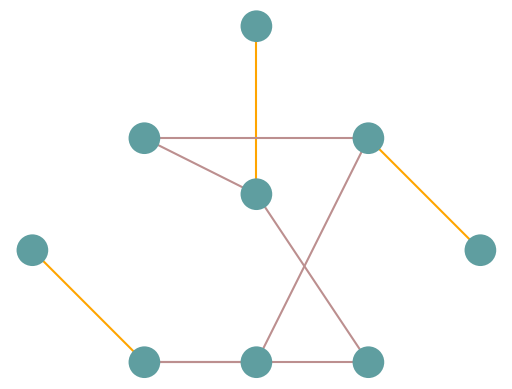

In [40]:
n = create_9_bus_network(plot=True) # create the network with some parameters

In [41]:
def model_results(n, print_results=False):
    n.pf()
    # Create DataFrame with bus results for all snapshots
    results_df = pd.DataFrame(
        index=n.snapshots,
        columns=pd.MultiIndex.from_product([
            n.buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )

    # Fill results for each snapshot
    for t in n.snapshots:
        for bus in n.buses.index:
            results_df.loc[t, (bus, 'P (MW)')] = n.buses_t.p.loc[t, bus]
            results_df.loc[t, (bus, 'Q (MVAr)')] = n.buses_t.q.loc[t, bus]
            results_df.loc[t, (bus, 'V (pu)')] = n.buses_t.v_mag_pu.loc[t, bus]
            results_df.loc[t, (bus, 'Angle (deg)')] = n.buses_t.v_ang.loc[t, bus]

    if print_results:
        print("\nBus Results:") 
        print(results_df)

    return results_df


In [42]:
df=model_results(n,print_results=True) # run the power flow and store results in df. Print if print_results = True

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2025-02-12 00:00:00', '2025-02-12 01:00:00',
               '2025-02-12 02:00:00', '2025-02-12 03:00:00',
               '2025-02-12 04:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq='h')
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 498486191209591954106743999984304128.000000 in 0.463147 seconds
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 8426774594530476231119465575679524864.000000 in 0.487974 seconds
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 5533019506938357928258879164610772992.000000 in 0.502789 seconds
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 884668163812888804878368093899849728.000000 in 0.605802 seconds
INFO:pypsa.pf:Newton-Raphson solved in 100 iterations with error of 65970432336695173072523459279127052288.000000 in 0.575122 seconds



Bus Results:
Bus                                  Bus 1                                \
                                    P (MW)               Q (MVAr) V (pu)   
snapshot                                                                   
2025-02-12 00:00:00 -1528140545524240128.0  -966487306211561984.0   1.04   
2025-02-12 01:00:00                   -0.0            2086.419753   1.04   
2025-02-12 02:00:00   -76109737782195616.0    -1667360739900021.5   1.04   
2025-02-12 03:00:00   689728316535546496.0 -2008960423001921536.0   1.04   
2025-02-12 04:00:00  -200941010574153792.0   303143561385494016.0   1.04   

Bus                              Bus 2                                 \
                    Angle (deg) P (MW) Q (MVAr)                V (pu)   
snapshot                                                                
2025-02-12 00:00:00         0.0  163.0      0.0   -4439225291345198.0   
2025-02-12 01:00:00         0.0  163.0      0.0                   0.0   
2025-02-12 0